In [1]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

import requests
from PIL import Image
from io import BytesIO

from sklearn.metrics import confusion_matrix
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

from torchvision import transforms

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader,Dataset,ConcatDataset

from skimage.io import imread
from skimage.transform import resize
from skimage.util import invert



##Getting Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_data = pd.read_csv("/content/drive/MyDrive/dataset/train_data.csv")
test_data = pd.read_csv("/content/drive/MyDrive/dataset/test_data.csv")
df = pd.concat([train_data, test_data], sort=False)
# display(train[0:5])
# display(test[0:5])

In [5]:
df.shape

(74012, 785)

In [6]:
y = df['label'].values
X = df.drop(['label'],1).values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

<ipython-input-6-7f3eeca68fc0>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(['label'],1).values


In [7]:
print(y_test.shape)

(14803,)


In [8]:
BATCH_SIZE = 64
torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

torch_X_train = torch_X_train.view(-1, 1,28,28).float()
torch_X_test = torch_X_test.view(-1,1,28,28).float()
print(torch_X_train.shape)
print(torch_X_test.shape)



# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)

test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

torch.Size([59209, 1, 28, 28])
torch.Size([14803, 1, 28, 28])


In [12]:
mean = [0.2812668149052327]
std = [0.349463855153678]



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TT = transform=transforms.Compose([
                      # transforms.ToPILImage(),
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip(),
                      transforms.RandomRotation(15),
                      transforms.RandomRotation([90, 180]),
                      transforms.Resize([28, 28]),
                      transforms.RandomCrop([28, 28]),
                      transforms.ToTensor(),
                      transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
                      ])






T = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

##Creating Model

In [80]:
class Net1(nn.Module):

    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,11)

        self.dropout = nn.Dropout(0.2)
        

    def forward(self, x):
        # one activated conv layer
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x
cnn = Net1()

In [14]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [15]:
network = Net1()
optimizer = optim.SGD(network.parameters(), lr=0.001,
                      momentum=0.9)

In [16]:

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [17]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/content/drive/MyDrive/model/modelfix.pth')
      torch.save(optimizer.state_dict(), '/content/drive/MyDrive/model/optimizerfix.pth')

In [18]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [19]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 6.0479, Accuracy: 1442/14803 (10%)

Train Epoch: 1 [0/59209 (0%)]	Loss: 8.882679
Train Epoch: 1 [640/59209 (1%)]	Loss: 2.205281
Train Epoch: 1 [1280/59209 (2%)]	Loss: 1.759655
Train Epoch: 1 [1920/59209 (3%)]	Loss: 1.612567
Train Epoch: 1 [2560/59209 (4%)]	Loss: 1.336910
Train Epoch: 1 [3200/59209 (5%)]	Loss: 1.057609
Train Epoch: 1 [3840/59209 (6%)]	Loss: 1.443294
Train Epoch: 1 [4480/59209 (8%)]	Loss: 1.547410
Train Epoch: 1 [5120/59209 (9%)]	Loss: 1.289851
Train Epoch: 1 [5760/59209 (10%)]	Loss: 1.162594
Train Epoch: 1 [6400/59209 (11%)]	Loss: 1.345248
Train Epoch: 1 [7040/59209 (12%)]	Loss: 1.211053
Train Epoch: 1 [7680/59209 (13%)]	Loss: 0.971984
Train Epoch: 1 [8320/59209 (14%)]	Loss: 1.449372
Train Epoch: 1 [8960/59209 (15%)]	Loss: 1.025369
Train Epoch: 1 [9600/59209 (16%)]	Loss: 1.157927
Train Epoch: 1 [10240/59209 (17%)]	Loss: 0.940750
Train Epoch: 1 [10880/59209 (18%)]	Loss: 0.922666
Train Epoch: 1 [11520/59209 (19%)]	Loss: 0.849463
Train Epoch: 1 [12160

In [20]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [21]:
with torch.no_grad():
  output = network(example_data)

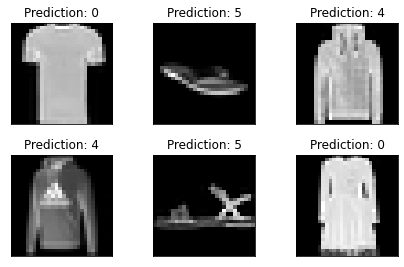

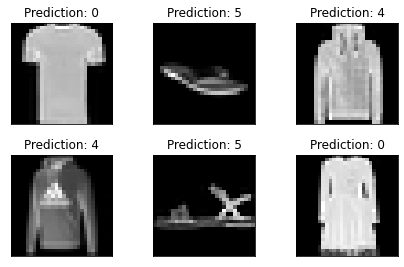

In [22]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [23]:
continued_network = Net1()
continued_optimizer = optim.SGD(continued_network.parameters(), lr=0.001,
                                momentum=0.9)

In [24]:
network_state_dict = torch.load("/content/drive/MyDrive/model/modelfix.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("/content/drive/MyDrive/model/optimizerfix.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

In [25]:
for i in range(4,20):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

Train Epoch: 4 [0/59209 (0%)]	Loss: 0.576916
Train Epoch: 4 [640/59209 (1%)]	Loss: 0.602322
Train Epoch: 4 [1280/59209 (2%)]	Loss: 0.572718
Train Epoch: 4 [1920/59209 (3%)]	Loss: 0.632296
Train Epoch: 4 [2560/59209 (4%)]	Loss: 0.330459
Train Epoch: 4 [3200/59209 (5%)]	Loss: 0.494344
Train Epoch: 4 [3840/59209 (6%)]	Loss: 0.822211
Train Epoch: 4 [4480/59209 (8%)]	Loss: 0.500419
Train Epoch: 4 [5120/59209 (9%)]	Loss: 0.642194
Train Epoch: 4 [5760/59209 (10%)]	Loss: 0.431765
Train Epoch: 4 [6400/59209 (11%)]	Loss: 0.391870
Train Epoch: 4 [7040/59209 (12%)]	Loss: 0.497202
Train Epoch: 4 [7680/59209 (13%)]	Loss: 0.542296
Train Epoch: 4 [8320/59209 (14%)]	Loss: 0.883843
Train Epoch: 4 [8960/59209 (15%)]	Loss: 0.455790
Train Epoch: 4 [9600/59209 (16%)]	Loss: 0.540781
Train Epoch: 4 [10240/59209 (17%)]	Loss: 0.459852
Train Epoch: 4 [10880/59209 (18%)]	Loss: 0.541514
Train Epoch: 4 [11520/59209 (19%)]	Loss: 0.320155
Train Epoch: 4 [12160/59209 (21%)]	Loss: 0.505879
Train Epoch: 4 [12800/59209 (

In [26]:
with torch.no_grad():
  output1 = continued_network(example_data)

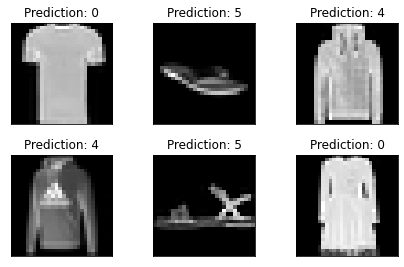

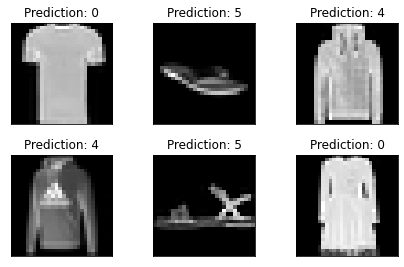

In [27]:
# for i in range(20):
#   print("{}".format(output1.data.max(1, keepdim=True)[1][i].item()))
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig


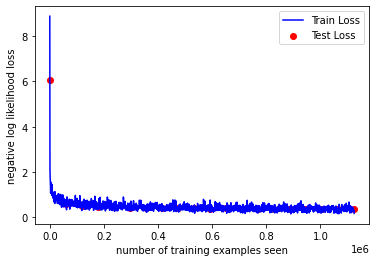

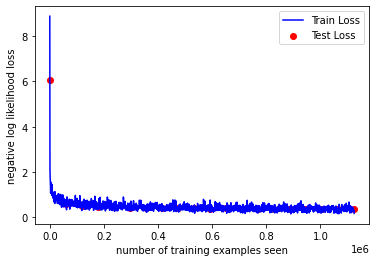

In [28]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

##Validation Function

In [31]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [32]:
y_pred, y_true = predict_dl(continued_network, test_loader)

##Confusion Matrix

In [33]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,11)))

,0,1,2,3,4,5,6,7,8,9,10
0,1315,6,29,24,5,0,127,1,18,0,0
1,6,1328,3,21,4,0,6,0,1,0,0
2,26,1,882,3,321,0,152,0,35,0,0
3,158,32,20,1040,94,0,50,0,11,1,0
4,17,5,135,33,1035,0,198,0,18,0,2
5,4,3,1,3,0,1267,1,87,27,55,7
6,305,3,164,16,168,0,670,1,28,0,0
7,1,1,0,0,0,74,1,1460,6,48,8
8,13,0,21,4,10,5,23,7,1447,4,3
9,1,0,1,4,0,26,0,82,5,1352,10


##Interference Function

##Predict Data Result

In [34]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax2.barh(np.arange(11), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(11))
    ax2.set_yticklabels(np.arange(11))
    ax2.set_yticklabels(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle Boot',
                        'hat'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

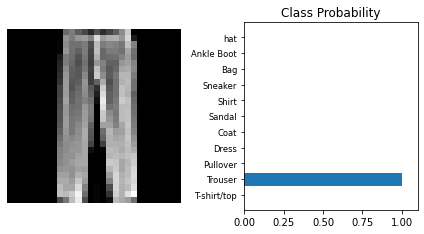

In [79]:
%matplotlib inline
def make_prediction(data):
    images, labels = next(iter(data))
    image_index = 34
    img = images[image_index].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = continued_network(img)


    

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    view_classify(img.view(1, 28, 28), ps)
make_prediction(test_loader)


In [38]:
classes = [
    "T-shirt/Top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boat",
    "Hat",
]

In [39]:
model = Net1()
continued_optimizer = optim.SGD(model.parameters(), lr=0.001,
                                momentum=0.5)

In [40]:
network_state_dict = torch.load("/content/drive/MyDrive/model/modelfix.pth")
model.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("/content/drive/MyDrive/model/optimizerfix.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

In [41]:
mean = [0.2859]
std = [0.3530]



image_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [42]:
def classify(model,image_transform, image_path, classes):
  model = model.eval()
  image = Image.open(image_path).convert('L')
  image = image.resize((28, 28))
  image = image_transform(image).float()
  image = image.unsqueeze(axis=0)

  output = model(image)
  _, predicted = torch.max(output, 1)
  print(classes[predicted.item()])



Bag


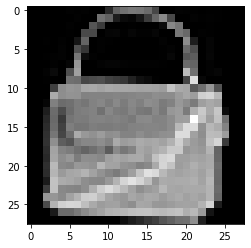

In [45]:
image_paths = "/content/drive/MyDrive/jury/Copy of mnist_358.png"
classify(model, image_transform, image_paths, classes)
image = Image.open(image_paths)
plt.imshow(image, cmap='gray')


Dress


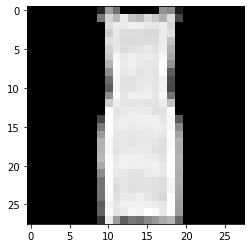

In [70]:
image_paths = "/content/drive/MyDrive/jury/Copy of mnist_58.png"
classify(model, image_transform, image_paths, classes)
image = Image.open(image_paths)
plt.imshow(image, cmap='gray')


Pullover


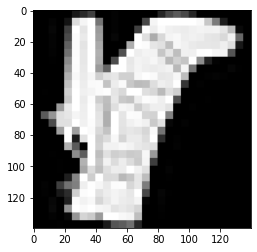

In [67]:
image_paths = "/content/drive/MyDrive/jury/Copy of mnist_11_shoes.png"
classify(model, image_transform, image_paths, classes)
image = Image.open(image_paths)
plt.imshow(image, cmap='gray')

Sneaker


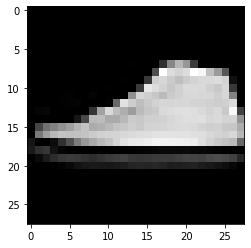

In [47]:
image_paths = "/content/drive/MyDrive/jury/Copy of mnist_41.png"
classify(model, image_transform, image_paths, classes)
image = Image.open(image_paths)
plt.imshow(image, cmap='gray')

Bag


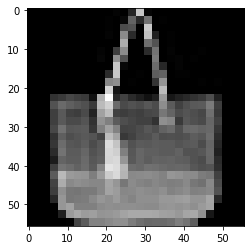

In [49]:
image_paths = "/content/drive/MyDrive/jury/Copy of mnist_35_bag.png"
classify(model, image_transform, image_paths, classes)
image = Image.open(image_paths)
plt.imshow(image, cmap='gray')

Sneaker


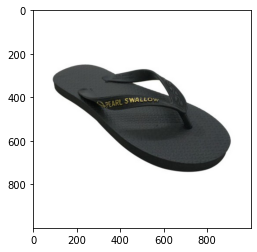

In [68]:
image_paths = "/content/drive/MyDrive/jury/Copy of sandal_1.jpeg"
classify(model, image_transform, image_paths, classes)
image = Image.open(image_paths)
plt.imshow(image, cmap='gray')

Pullover


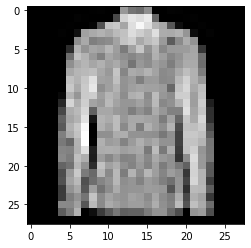

In [65]:
image_paths = "/content/drive/MyDrive/jury/Copy of mnist_112.png"
classify(model, image_transform, image_paths, classes)
image = Image.open(image_paths)
plt.imshow(image, cmap='gray')

Sneaker


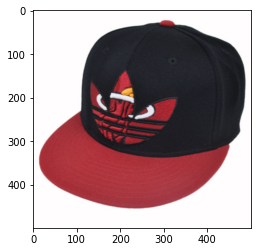

In [71]:
image_paths = "/content/drive/MyDrive/jury/Copy of hat_3.jpg"
classify(model, image_transform, image_paths, classes)
image = Image.open(image_paths)
plt.imshow(image, cmap='gray')

Pullover


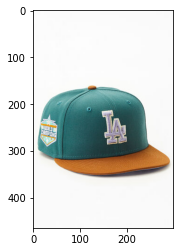

In [72]:
image_paths = "/content/drive/MyDrive/jury/Copy of hat_4.jpg"
classify(model, image_transform, image_paths, classes)
image = Image.open(image_paths)
plt.imshow(image, cmap='gray')

Pullover


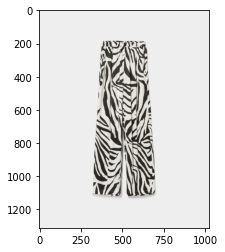

In [74]:
image_paths = "/content/drive/MyDrive/jury/Copy of trouser_1.jpg"
classify(model, image_transform, image_paths, classes)
image = Image.open(image_paths)
plt.imshow(image, cmap='gray')